

![Simulated Annealing](SA_animation.gif)


In [2]:
import json
import copy

import numpy as np  # contains helpful math functions like numpy.exp()
import numpy.random as random  # see numpy.random module
# import random  # alternative to numpy.random module

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
"""Read input data and define helper functions for visualization."""

map = mpimg.imread("map.png")  # US States & Capitals map

with open('capitals.json', 'r') as capitals_file:
    capitals = json.load(capitals_file)
capitals_list = list(capitals.items())

def show_path(path, starting_city, w=12, h=8):
    """Plot a TSP path overlaid on a map of the US States & their capitals."""
    x, y = list(zip(*path))
    _, (x0, y0) = starting_city
    plt.imshow(map)
    plt.plot(x0, y0, 'y*', markersize=15)  # y* = yellow star for starting point
    plt.plot(x + x[:1], y + y[:1])  # include the starting point at the end of path
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])

# Simulated Annealing -- Main Loop



In [5]:
def simulated_annealing(problem, schedule):
    """The simulated annealing algorithm, a version of stochastic hill climbing
    where some downhill moves are allowed. Downhill moves are accepted readily
    early in the annealing schedule and then less often as time goes on. The
    schedule input determines the value of the temperature T as a function of
    time. 
    
    Parameters
    ----------
    problem : Problem
        An optimization problem, already initialized to a random starting state.
        The Problem class interface must implement a callable method
        "successors()" which returns states in the neighborhood of the current
        state, and a callable function "get_value()" which returns a fitness
        score for the state. (See the `TravelingSalesmanProblem` class below
        for details.)

    schedule : callable
        A function mapping time to "temperature". "Time" is equivalent in this
        case to the number of loop iterations.
    
    Returns
    -------
    Problem
        An approximate solution state of the optimization problem
"""
    ct = 1
    while True:
        T = schedule(ct)
        
        if T < 1e-10:
            return problem
        
        next_problem = np.random.choice(problem.successors())
        
        delta_E = next_problem.get_value() - problem.get_value()
        
        if delta_E > 0:
            problem = next_problem
        elif np.random.rand() < np.exp(delta_E/T):
            problem = next_problem
        
        ct +=1
    

## III. Representing the Problem

In order to use simulated annealing we need to build a representation of the problem domain.  The choice of representation can have a significant impact on the performance of simulated annealing and other optimization techniques.  Since the TSP deals with a closed loop that visits each city in a list once, we will represent each city by a tuple containing the city name and its position specified by an (x,y) location on a grid.  The _state_ will then consist of an ordered sequence (a list) of the cities; the path is defined as the sequence generated by traveling from each city in the list to the next in order. By default you should use the Euclidean distance metric to measure the path length.

In [54]:
class TravelingSalesmanProblem:
    """Representation of a traveling salesman optimization problem.  The goal
    is to find the shortest path that visits every city in a closed loop path.
    
    Students should only need to implement or modify the successors() and
    get_values() methods.
    
    Parameters
    ----------
    cities : list
        A list of cities specified by a tuple containing the name and the x, y
        location of the city on a grid. e.g., ("Atlanta", (585.6, 376.8))
    
    Attributes
    ----------
    names
    coords
    path : list
        The current path between cities as specified by the order of the city
        tuples in the list.
    """
    def __init__(self, cities):
        self.path = copy.deepcopy(cities)
    
    def copy(self):
        """Return a copy of the current board state."""
        new_tsp = TravelingSalesmanProblem(self.path)
        return new_tsp
    
    @property
    def names(self):
        """Strip and return only the city name from each element of the
        path list. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> ["Atlanta", ...]
        """
        names, _ = zip(*self.path)
        return names
    
    @property
    def coords(self):
        """Strip the city name from each element of the path list and return
        a list of tuples containing only pairs of xy coordinates for the
        cities. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> [(585.6, 376.8), ...]
        """
        _, coords = zip(*self.path)
        return coords
    
    def successors(self):
        """Return a list of states in the neighborhood of the current state by
        switching the order in which any adjacent pair of cities is visited.
        
        For example, if the current list of cities (i.e., the path) is [A, B, C, D]
        then the neighbors will include [A, B, D, C], [A, C, B, D], [B, A, C, D],
        and [D, B, C, A]. (The order of successors does not matter.)
        
        In general, a path of N cities will have N neighbors.

        Returns
        -------
        list<Problem>
            A list of TravelingSalesmanProblem instances initialized with their list
            of cities set to one of the neighboring permutations of cities in the
            present state
        """   
        all_permutations = []
        previous_city = len(self.path)-1
        for idx, cities in enumerate(self.path):
            current_path = copy.deepcopy(self.path)
            previous = current_path[previous_city]
            current_path[idx] = previous
            current_path[previous_city] = cities
            all_permutations.append(TravelingSalesmanProblem(current_path))
            previous_city = idx
        return all_permutations
       

    def get_value(self):
        """Calculate the total length of the closed-circuit path of the current
        state by summing the distance between every pair of adjacent cities.  
        
        Returns
        -------
        float
            A floating point value with the total cost of the path given by visiting
            the cities in the order according to the self.cities list
        
        """    
        cities_n = len(self.path)
        (last_dist_x, last_dist_y) = self.path[-1][1]
        fitness = 0.
        for city in self.path:   
            (coord_x, coord_y) = (city[1])
            fitness += np.sqrt(np.square(coord_x - last_dist_x)+ np.square(coord_y - last_dist_y))
            last_dist_x, last_dist_y = coord_x, coord_y
        return -fitness 

### Testing TravelingSalesmanProblem
The following tests should validate the class constructor and functionality of the `successors()` and `get_value()` methods.

In [55]:
# Construct an instance of the TravelingSalesmanProblem
test_cities = [('DC', (11, 1)), ('SF', (0, 0)), ('PHX', (2, -3)), ('LA', (0, -4))]
tsp = TravelingSalesmanProblem(test_cities)
assert(tsp.path == test_cities)

In [56]:
# Test the successors() method -- no output means the test passed
successor_paths = [x.path for x in tsp.successors()]
assert(all(x in [[('LA', (0, -4)), ('SF', (0, 0)), ('PHX', (2, -3)), ('DC', (11, 1))],
                 [('SF', (0, 0)), ('DC', (11, 1)), ('PHX', (2, -3)), ('LA', (0, -4))],
                 [('DC', (11, 1)), ('PHX', (2, -3)), ('SF', (0, 0)), ('LA', (0, -4))],
                 [('DC', (11, 1)), ('SF', (0, 0)), ('LA', (0, -4)), ('PHX', (2, -3))]]
          for x in successor_paths)) 

In [57]:
# Test the get_value() method -- no output means the test passed
assert(np.allclose(tsp.get_value(), -28.97, atol=1e-3))

## Define the Temperature Schedule



In [58]:
alpha = 0.95
temperature=1e4

def schedule(time):
    return (alpha ** time) * temperature


### Testing the Temperature Schedule
The following tests should validate the temperature schedule function and perform a simple test of the simulated annealing function to solve a small TSP test case

In [59]:
# test the schedule() function -- no output means that the tests passed
assert(np.allclose(alpha, 0.95, atol=1e-3))
assert(np.allclose(schedule(0), temperature, atol=1e-3))
assert(np.allclose(schedule(10), 5987.3694, atol=1e-3))

In [60]:
# Failure implies that the initial path of the test case has been changed
assert(tsp.path == [('DC', (11, 1)), ('SF', (0, 0)), ('PHX', (2, -3)), ('LA', (0, -4))])
result = simulated_annealing(tsp, schedule)
print("Initial score: {}\nStarting Path: {!s}".format(tsp.get_value(), tsp.path))
print("Final score: {}\nFinal Path: {!s}".format(result.get_value(), result.path))
assert(tsp.path != result.path)
assert(result.get_value() > tsp.get_value())

Initial score: -28.97002624374561
Starting Path: [('DC', (11, 1)), ('SF', (0, 0)), ('PHX', (2, -3)), ('LA', (0, -4))]
Final score: -27.130286796483155
Final Path: [('SF', (0, 0)), ('DC', (11, 1)), ('PHX', (2, -3)), ('LA', (0, -4))]


Run Simulated Annealing on a Larger TSP


Initial path value: 3074.15
[('Oklahoma City', [392.8, 356.4]), ('Montgomery', [559.6, 404.8]), ('Saint Paul', [451.6, 186.0]), ('Trenton', [698.8, 239.6]), ('Salt Lake City', [204.0, 243.2]), ('Columbus', [590.8, 263.2]), ('Austin', [389.2, 448.4]), ('Phoenix', [179.6, 371.2]), ('Hartford', [719.6, 205.2]), ('Baton Rouge', [489.6, 442.0])]


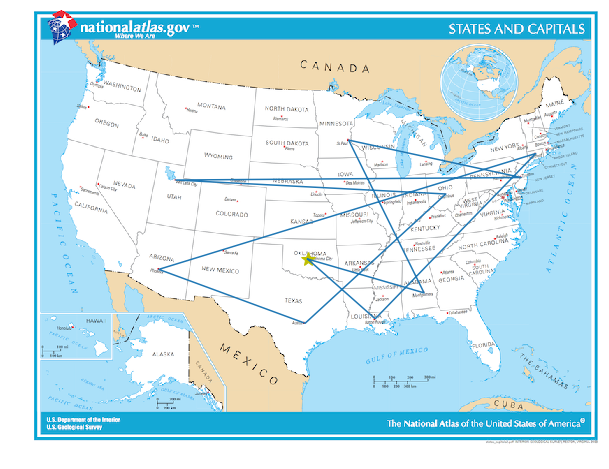

In [63]:

num_cities = 10
capitals_tsp = TravelingSalesmanProblem(capitals_list[:num_cities])
starting_city = capitals_list[0]
print("Initial path value: {:.2f}".format(-capitals_tsp.get_value()))
print(capitals_list[:num_cities])  # The start/end point is indicated with a yellow star
show_path(capitals_tsp.coords, starting_city)

Final path length: 1608.67
[('Saint Paul', [451.6, 186.0]), ('Austin', [389.2, 448.4]), ('Phoenix', [179.6, 371.2]), ('Salt Lake City', [204.0, 243.2]), ('Oklahoma City', [392.8, 356.4]), ('Baton Rouge', [489.6, 442.0]), ('Montgomery', [559.6, 404.8]), ('Trenton', [698.8, 239.6]), ('Hartford', [719.6, 205.2]), ('Columbus', [590.8, 263.2])]


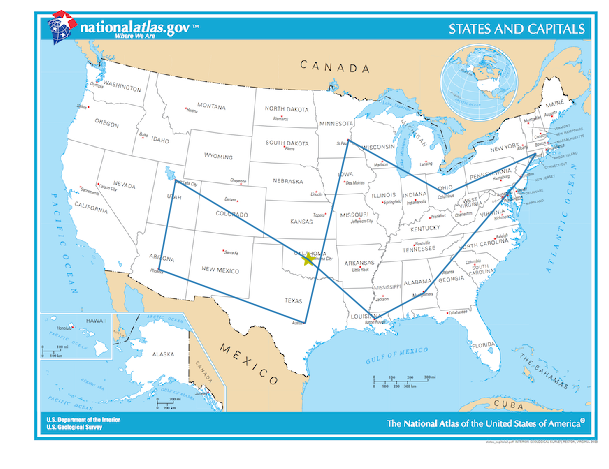

In [62]:
alpha = 0.95
temperature=1e6
result = simulated_annealing(capitals_tsp, schedule)
print("Final path length: {:.2f}".format(-result.get_value()))
print(result.path)
show_path(result.coords, starting_city)